<a href="https://colab.research.google.com/github/Bharathkumar1404/data-science-final-project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INTIALIZING THE LIBRARIES

In [9]:
#Initializing the matplotlib library
!pip install matplotlib

In [10]:
#Intializing the pmdarima library
!pip install pmdarima

In [11]:
#Initializing the prophet model library
!pip install prophet

In [12]:
#Initializing the statsmodels library
!pip install statsmodels

IMPORTING THE REQURIED LIBRARIES

In [13]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Dense, Flatten
#from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

In [14]:
# Importing the dataset using pandas' read_csv() function.
weather_data = pd.read_csv('pune.csv')
weather_data.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,...,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2008-12-11 00:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,10,31,72,0.0,1013,18,10,114,5,pune
1,2008-12-11 01:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,9,30,72,0.0,1013,19,10,125,4,pune
2,2008-12-11 02:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,8,29,72,0.0,1013,18,10,136,4,pune
3,2008-12-11 03:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,8,29,72,0.0,1013,18,10,147,4,pune
4,2008-12-11 04:00:00,30,18,0.0,11.0,6,93,04:33 PM,05:13 AM,06:57 AM,...,7,23,68,0.0,1014,20,10,136,4,pune


In [15]:
#Dropping irrelevant columns from the weather_data DataFrame and displaying the first 5 rows of the cleaned data.
wf = weather_data.drop(columns=['DewPointC','cloudcover','moonrise', 'moonset', 'sunrise', 'sunset','sunHour','totalSnow_cm','uvIndex','moon_illumination','visibility','winddirDegree','windspeedKmph'])
wf.head()

,date_time,maxtempC,mintempC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,humidity,precipMM,pressure,tempC,location
0,2008-12-11 00:00:00,30,18,18,18,18,10,72,0.0,1013,18,pune
1,2008-12-11 01:00:00,30,18,19,19,19,9,72,0.0,1013,19,pune
2,2008-12-11 02:00:00,30,18,18,18,18,8,72,0.0,1013,18,pune
3,2008-12-11 03:00:00,30,18,18,18,18,8,72,0.0,1013,18,pune
4,2008-12-11 04:00:00,30,18,20,20,20,7,68,0.0,1014,20,pune


In [16]:
# Converting 'date_time' to datetime format and extracting year, month, day, and hour; filtering data for years between 2009 and 2021.
wf['date_time'] = pd.to_datetime(wf['date_time'])
wf['date_time'] = pd.to_datetime(wf['date_time'])
wf['year'] = wf['date_time'].dt.year
wf['month'] = wf['date_time'].dt.month
wf['day'] = wf['date_time'].dt.day
wf['hour'] = wf['date_time'].dt.hour

wf = wf[wf['year'] > 2008]
wf = wf[wf['year'] < 2022]

In [17]:
# Resetting the index of the DataFrame and dropping the old index to ensure sequential indexing.
wf = wf.reset_index(drop= True)

In [18]:
# Displaying a concise summary of the DataFrame, including column names, non-null counts, and data types.
print(wf.info())

# Displaying descriptive statistics for the numeric columns in the DataFrame, such as mean, std, min, and max values.
print(wf.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113952 entries, 0 to 113951
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   date_time     113952 non-null  datetime64[ns]
 1   maxtempC      113952 non-null  int64         
 2   mintempC      113952 non-null  int64         
 3   FeelsLikeC    113952 non-null  int64         
 4   HeatIndexC    113952 non-null  int64         
 5   WindChillC    113952 non-null  int64         
 6   WindGustKmph  113952 non-null  int64         
 7   humidity      113952 non-null  int64         
 8   precipMM      113952 non-null  float64       
 9   pressure      113952 non-null  int64         
 10  tempC         113952 non-null  int64         
 11  location      113952 non-null  object        
 12  year          113952 non-null  int32         
 13  month         113952 non-null  int32         
 14  day           113952 non-null  int32         
 15  hour          113

In [19]:
# Calculating the number of missing values in each column of the DataFrame.
missing_values = wf.isnull().sum()

# Printing the count of missing values for each column to identify data quality issues.
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 date_time       0
maxtempC        0
mintempC        0
FeelsLikeC      0
HeatIndexC      0
WindChillC      0
WindGustKmph    0
humidity        0
precipMM        0
pressure        0
tempC           0
location        0
year            0
month           0
day             0
hour            0
dtype: int64


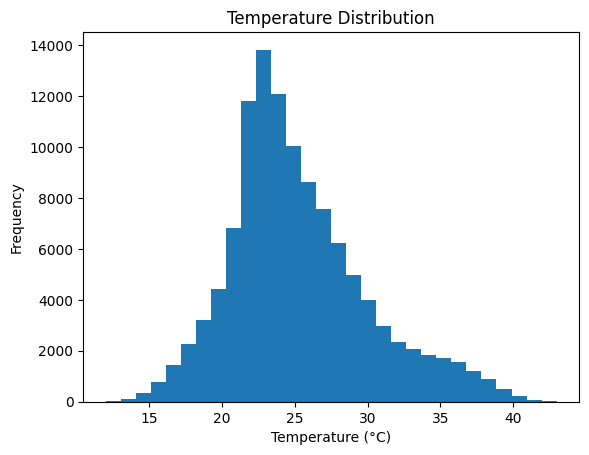

In [20]:
# Plotting a histogram to visualize the distribution of the 'tempC' column (temperature data).
wf['tempC'].plot(kind='hist', bins=30, title='Temperature Distribution')
plt.xlabel('Temperature (°C)')
plt.show()

year
2009    25.416210
2010    24.967808
2011    25.084817
2012    25.401753
2013    25.117009
2014    25.387100
2015    25.354566
2016    25.123634
2017    25.451027
2018    25.830023
2019    25.528311
2020    25.433629
2021    25.333219
Name: tempC, dtype: float64


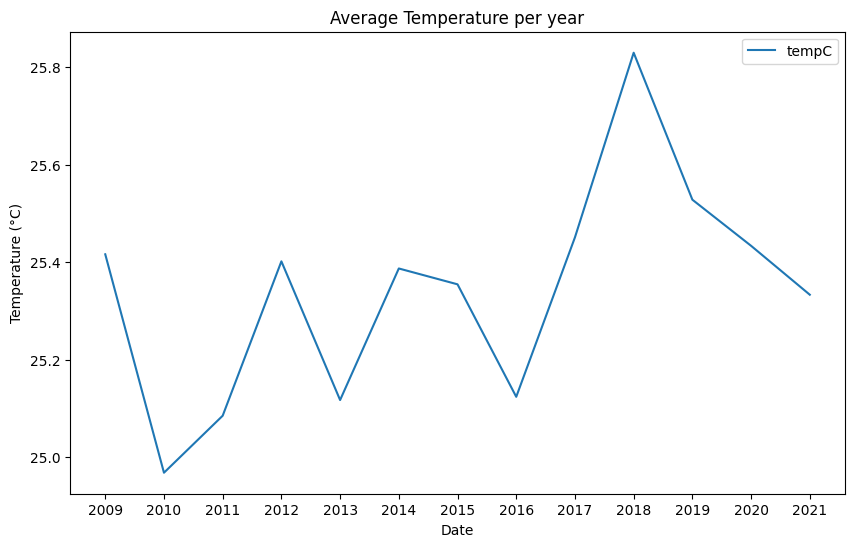

In [21]:
# Sorting the DataFrame by 'date_time' column
wf = wf.sort_values(by='date_time')

# Calculating the average temperature ('tempC') per year.
wfg = wf.groupby('year')['tempC'].mean()
print(wfg)

# Resetting the index for easier plotting and plotting a line graph of yearly average temperature.
wfg = wfg.reset_index()
wfg.plot(x='year', y='tempC', kind='line', figsize=(10, 6))

# Adding labels and title for the plot.
plt.xticks(wfg['year'].unique())
plt.title('Average Temperature per year')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()


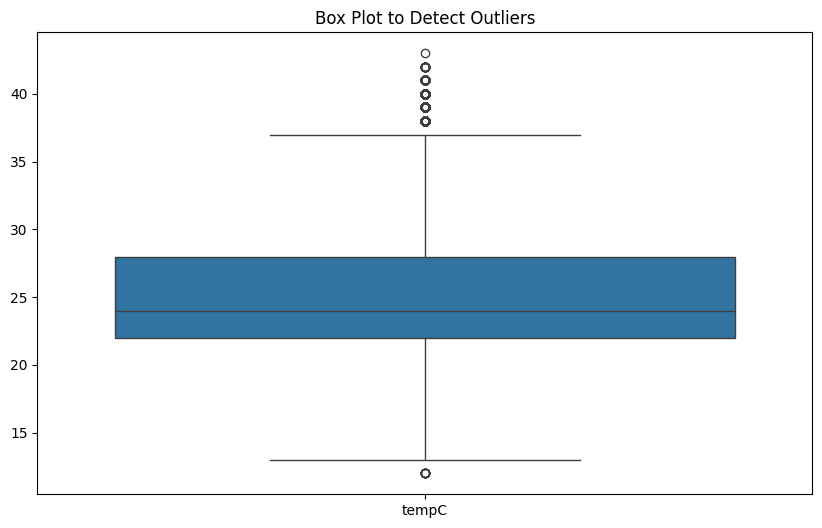

Number of outliers in Temperature: 1718
Original DataFrame shape: (113952, 16)
        year  tempC
1356    2009     38
1357    2009     38
1358    2009     38
1380    2009     38
1381    2009     38
...      ...    ...
107942  2021     39
107943  2021     39
107944  2021     39
107965  2021     38
107966  2021     38

[1718 rows x 2 columns]


In [22]:
# Plotting a boxplot for 'tempC' to visually detect outliers.
plt.figure(figsize=(10, 6))
sns.boxplot(data=wf[['tempC']])
plt.title('Box Plot to Detect Outliers')
plt.show()

# Calculating IQR and identifying outliers in 'tempC'.
Q1 = wf['tempC'].quantile(0.25)
Q3 = wf['tempC'].quantile(0.75)
IQR = Q3 - Q1
outliers_tempC = wf[(wf['tempC'] < (Q1 - 1.5 * IQR)) | (wf['tempC'] > (Q3 + 1.5 * IQR))]

# Printing the number of outliers and details of outlier rows.
print("Number of outliers in Temperature:", len(outliers_tempC))
print("Original DataFrame shape:", wf.shape)
print(outliers_tempC[['year', 'tempC']])





Original DataFrame shape: (113952, 16)
DataFrame without outliers shape: (112234, 16)
Number of outliers in Temperature: 112234
            date_time  maxtempC  mintempC  FeelsLikeC  HeatIndexC  WindChillC  \
0 2009-01-01 00:00:00        31        17          17          17          17   
1 2009-01-01 01:00:00        31        17          17          17          17   
2 2009-01-01 02:00:00        31        17          17          17          17   
3 2009-01-01 03:00:00        31        17          17          17          17   
4 2009-01-01 04:00:00        31        17          17          17          17   

   WindGustKmph  humidity  precipMM  pressure  tempC location  year  month  \
0             7        50       0.0      1013     17     pune  2009      1   
1             9        46       0.0      1013     17     pune  2009      1   
2            10        43       0.0      1013     17     pune  2009      1   
3            12        40       0.0      1013     17     pune  2009      

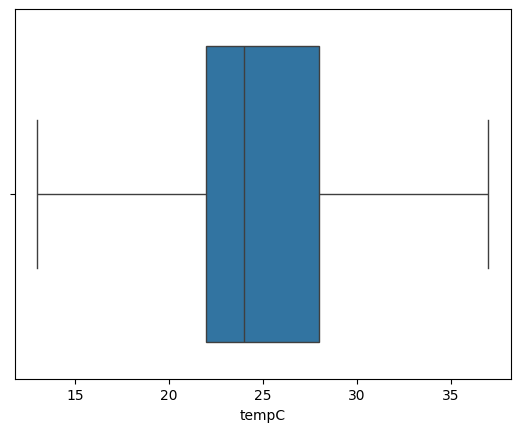

In [23]:
# Removing outliers from 'tempC' based on IQR thresholds and creating a new DataFrame.
wf_no_outliers = wf[(wf['tempC'] >= (Q1 - 1.5 * IQR)) & (wf['tempC'] <= (Q3 + 1.5 * IQR))]
wf_no_outliers.tail()

# Printing the shapes of the original and outlier-removed DataFrames for comparison.
print("Original DataFrame shape:", wf.shape)
print("DataFrame without outliers shape:", wf_no_outliers.shape)

# Plotting a boxplot of 'tempC' without outliers to confirm their removal.
sns.boxplot(x=wf_no_outliers['tempC'])

# Printing the number of rows in the outlier-free DataFrame and displaying the first few rows.
print("Number of outliers in Temperature:", len(wf_no_outliers))
print(wf_no_outliers.head())

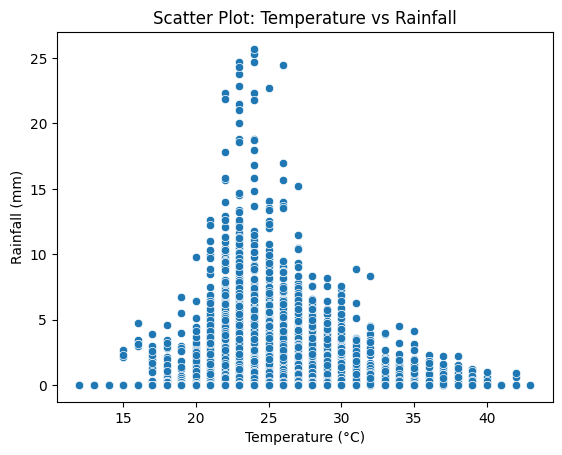

          tempC  precipMM
year                     
2009  25.416210  0.262340
2010  24.967808  0.269829
2011  25.084817  0.236416
2012  25.401753  0.155886
2013  25.117009  0.245959
2014  25.387100  0.207591
2015  25.354566  0.154749
2016  25.123634  0.259791
2017  25.451027  0.265982
2018  25.830023  0.188276
2019  25.528311  0.317146
2020  25.433629  0.302209
2021  25.333219  0.202489


In [24]:
# Plotting a scatter plot to visualize the relationship between temperature ('tempC') and rainfall ('precipMM').
sns.scatterplot(x='tempC', y='precipMM', data=wf)
plt.title('Scatter Plot: Temperature vs Rainfall')
plt.xlabel('Temperature (°C)')
plt.ylabel('Rainfall (mm)')
plt.show()

# Calculating the yearly average for temperature ('tempC') and rainfall ('precipMM').
wfs =wf.groupby('year')[['tempC','precipMM']].mean()
print(wfs)


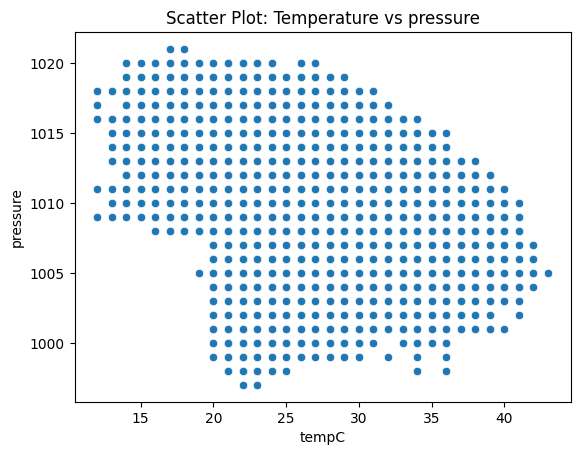

In [25]:
# Plotting a scatter plot to visualize the relationship between temperature ('tempC') and pressure.
sns.scatterplot(x='tempC', y='pressure', data=wf)
plt.title("Scatter Plot: Temperature vs pressure")
plt.show()


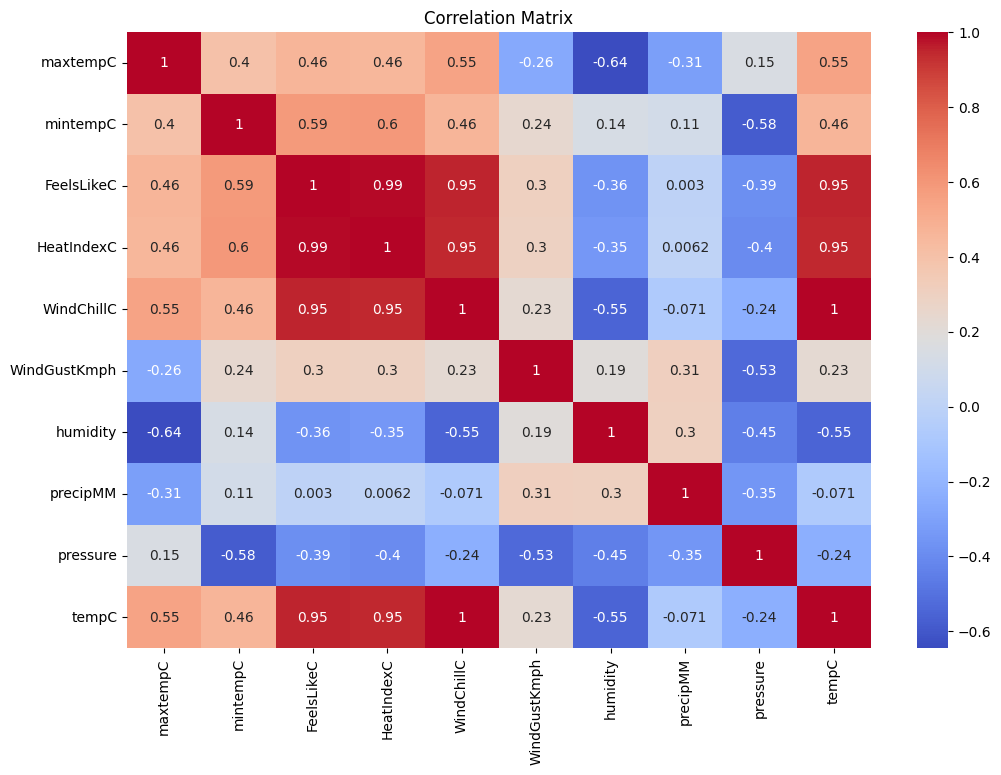

In [26]:
# Selecting only numeric columns from the DataFrame for correlation analysis.
numeric_data = wf.select_dtypes(include=['float64', 'int64'])

# Plotting a heatmap to visualize the correlation matrix of the numeric columns.
plt.figure(figsize=(12, 8))
corr_matrix = numeric_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [27]:
# Setting 'date_time' as the index and resampling data to daily averages for temperature, humidity, and pressure.
wf_no_outliers.set_index('date_time', inplace=True)
wf_daily_data = wf_no_outliers[['tempC', 'humidity', 'pressure']].resample('D').mean()

# Displaying the first 30 rows and the last few rows of the daily data.
print(wf_daily_data.head(30))
wf_daily_data.tail()

                tempC   humidity     pressure
date_time                                    
2009-01-01  22.541667  37.875000  1012.791667
2009-01-02  22.125000  44.000000  1013.750000
2009-01-03  22.583333  47.791667  1014.708333
2009-01-04  22.208333  52.791667  1013.583333
2009-01-05  22.458333  51.833333  1011.791667
2009-01-06  22.250000  47.583333  1011.833333
2009-01-07  22.041667  40.125000  1012.666667
2009-01-08  22.958333  42.541667  1014.458333
2009-01-09  22.875000  54.625000  1015.625000
2009-01-10  23.875000  54.708333  1014.958333
2009-01-11  24.541667  44.666667  1015.000000
2009-01-12  24.416667  43.208333  1016.916667
2009-01-13  23.250000  40.791667  1018.166667
2009-01-14  23.666667  37.125000  1018.416667
2009-01-15  23.500000  36.791667  1017.541667
2009-01-16  23.500000  38.166667  1017.083333
2009-01-17  23.291667  41.208333  1015.583333
2009-01-18  23.750000  40.250000  1014.375000
2009-01-19  24.166667  35.500000  1014.208333
2009-01-20  24.041667  29.750000  

,tempC,humidity,pressure
date_time,,,
2021-12-27,23.083333,44.208333,1014.708333
2021-12-28,22.833333,53.500000,1013.750000
2021-12-29,21.250000,53.333333,1014.083333
2021-12-30,21.250000,54.458333,1015.666667
2021-12-31,22.625000,48.416667,1016.333333


In [28]:
# # Converting 'tempC', 'humidity', and 'pressure' columns to integers and printing the updated data types.
wf_daily_data['tempC'] = wf_daily_data['tempC'].astype(int)
wf_daily_data['humidity'] = wf_daily_data['humidity'].astype(int)
wf_daily_data['pressure'] = wf_daily_data['pressure'].astype(int)
# print data types
print(wf_daily_data.dtypes)

tempC       int64
humidity    int64
pressure    int64
dtype: object


In [29]:
# Saving the daily resampled data to a CSV file named 'out.csv' without including the index.
wf_daily_data.to_csv('out.csv', index=False)

preprocessing

In [30]:
# Scaling 'tempC', 'humidity', and 'pressure' columns to a 0-1 range using MinMaxScaler.
scaler = MinMaxScaler()
wf_daily_data[['tempC', 'humidity', 'pressure']] = scaler.fit_transform(wf_daily_data[['tempC', 'humidity', 'pressure']])

# Creating lag features for 'tempC' and 'humidity' to capture temporal relationships.
wf_daily_data['temp_lag_1'] = wf_daily_data['tempC'].shift(1)
wf_daily_data['humidity_lag_1'] = wf_daily_data['humidity'].shift(1)
print(wf_daily_data.head())

# Backfilling missing values caused by lagging.
wf_daily_data.fillna(method = 'bfill',inplace=True)
wf_daily_data.head()

# Splitting the data into training (before 2019) and testing (after 2019) sets.
train = wf_daily_data[wf_daily_data.index <= pd.to_datetime('2019-01-01')]
test = wf_daily_data[wf_daily_data.index > pd.to_datetime('2019-01-01')]


               tempC  humidity  pressure  temp_lag_1  humidity_lag_1
date_time                                                           
2009-01-01  0.307692  0.306818      0.70         NaN             NaN
2009-01-02  0.307692  0.386364      0.75    0.307692        0.306818
2009-01-03  0.307692  0.420455      0.80    0.307692        0.386364
2009-01-04  0.307692  0.477273      0.75    0.307692        0.420455
2009-01-05  0.307692  0.465909      0.65    0.307692        0.477273


<ipython-input-30-8b23aa6267ee>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  wf_daily_data.fillna(method = 'bfill',inplace=True)


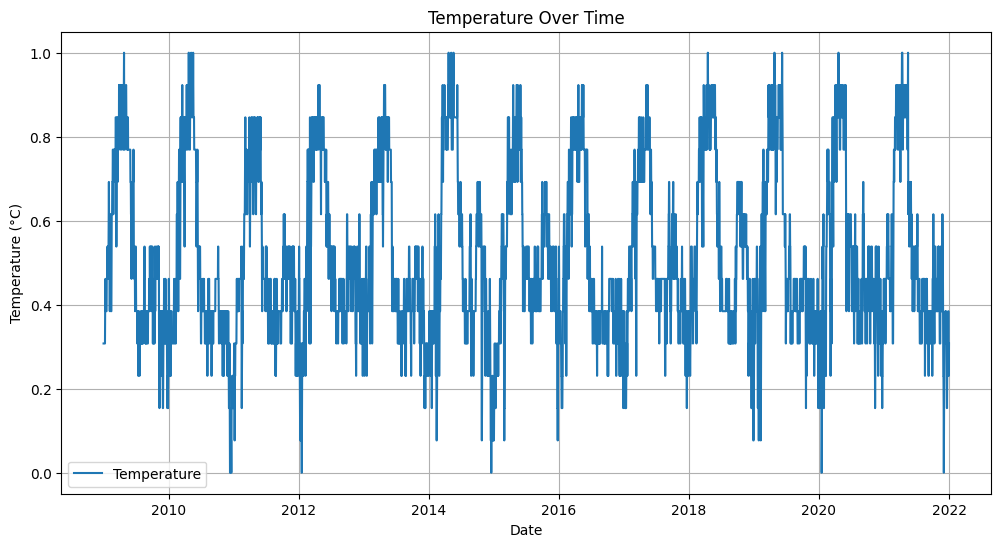

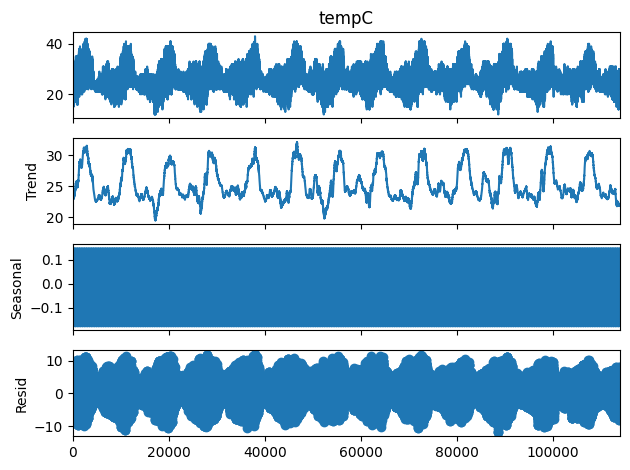

In [31]:
# Plotting temperature trends over time of original data.
plt.figure(figsize=(12, 6))
plt.plot(wf_daily_data.index,wf_daily_data['tempC'], label='Temperature')
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()

# Performing seasonal decomposition of temperature ('tempC') to analyze trends, seasonality, and residuals.
result = seasonal_decompose(wf['tempC'], model='additive', period=365)
result.plot()
plt.show()

ARIMA MODEL

In [32]:
# Function to check stationarity of a time series using the Augmented Dickey-Fuller (ADF) test.
def check_stationarity(series):
    """
    Check the stationarity of a time series using the Augmented Dickey-Fuller (ADF) test.

    Parameters:
    - series: pandas Series
        The time series to be tested for stationarity.

    Returns:
    - None: Prints the ADF statistic, p-value, and stationarity status.

    Key Steps:
    1. Perform the ADF test on the input series after removing NaN values.
    2. Print the ADF test statistic and the p-value.
    3. Determine stationarity based on the p-value:
       - If p-value < 0.05: The series is stationary.
       - Otherwise: The series is not stationary.
    """
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] < 0.05:
        print("The series is stationary.")
    else:
        print("The series is NOT stationary.")

# Checking stationarity of the 'tempC' column.
check_stationarity(wf['tempC'])

ADF Statistic: -8.60181633817182
p-value: 6.836621222378553e-14
The series is stationary.


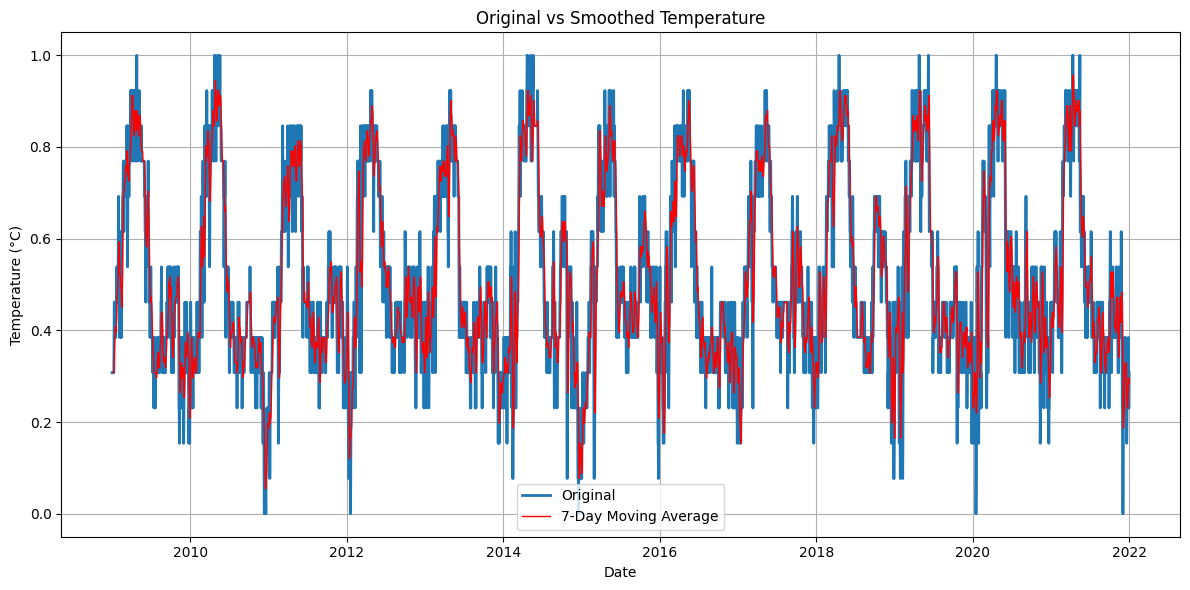

In [33]:
#Calculating a 7-day moving average for 'tempC' to to smooth the temperatue data
temperature_rolling = wf_daily_data['tempC'].rolling(window=7).mean()

#Plotting the original temperature data and the 7-day moving average
plt.figure(figsize=(12, 6))
plt.plot(wf_daily_data.index, wf_daily_data['tempC'], label='Original', linewidth=2)
plt.plot(wf_daily_data.index, temperature_rolling, label='7-Day Moving Average', color='red', linewidth=1)
plt.title('Original vs Smoothed Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()




<Figure size 1200x600 with 0 Axes>

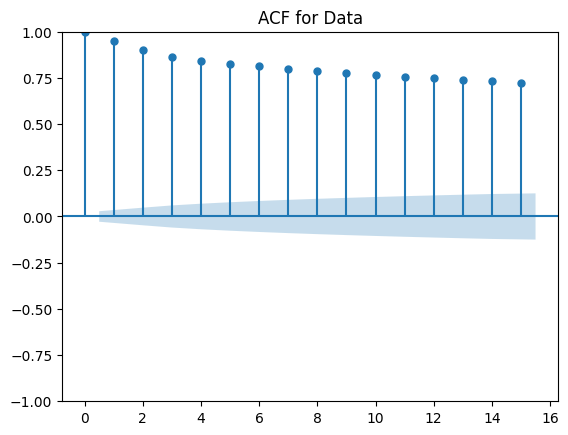

<Figure size 1200x600 with 0 Axes>

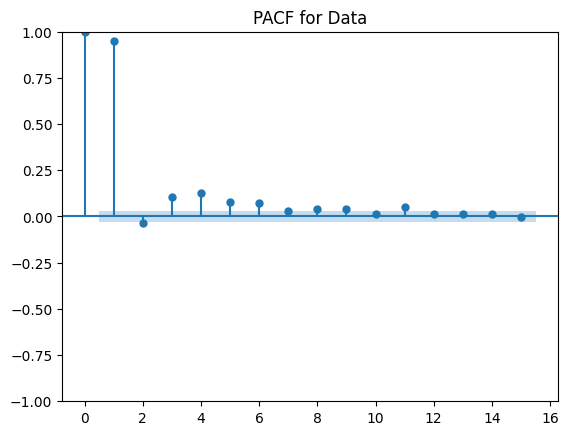

In [34]:
#Plotting the ACF to analyze lag dependencies in the data
plt.figure(figsize=(12, 6))
plot_acf(wf_daily_data['tempC'], lags=15)
plt.title('ACF for Data')
plt.show()

#Plotting the PACF to analyze direct correlations with lagged data
plt.figure(figsize=(12, 6))
plot_pacf(wf_daily_data['tempC'], lags=15)
plt.title('PACF for Data')
plt.show()

In [35]:
#Using auto-arima to automatically find the best ARIMA model for the training data('tempC')
#It searches through various combinations of p, d & q parameters basec on AIC(Akaike Information Criterion)
auto_model = auto_arima(train['tempC'],
                        start_p=0, start_q=0, #Starting values for p and q
                        max_p=5, max_q=5, #Maximum values for p and q
                        d=None, #Automatically determine the differencing oredr
                        seasonal=False, #Non-seasonal Arima model
                        stepwise=True, #Stepwise search to speedup the process
                        trace=True, #Display progress during model selection
                        error_action='ignore', #Ignore erorrs during the search
                        suppress_warnings=True, #Suppress waring messages
                        max_order=None, #NO limit on the sum of p and q
                        information_criterion='aic' #Use AIC to choose the best model
                        )

#Printing a summary of the selected ARiMA model
print(auto_model.summary())


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6027.736, Time=0.21 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.22 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1503.837, Time=0.71 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-10039.722, Time=1.72 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=4.18 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-10132.545, Time=0.59 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-1784.926, Time=0.84 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=3.11 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-10238.321, Time=1.30 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-3817.682, Time=1.06 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-10261.911, Time=4.81 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-10259.752, Time=3.05 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,4)(0,0,0)[0]             : AIC=-10259.471, Time=2.71 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-10255.638, Time=1.64 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=8.85 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,4)(0,0,0)[0]             : AIC=-10258.230, Time=4.37 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-10264.282, Time=9.91 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-10263.234, Time=6.17 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-10269.723, Time=10.53 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-10176.370, Time=3.94 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-10120.884, Time=8.99 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-10264.201, Time=7.32 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-10116.397, Time=2.30 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-10260.866, Time=8.39 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-10260.697, Time=10.38 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0] intercept
Total fit time: 107.360 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3653
Model:               SARIMAX(2, 0, 2)   Log Likelihood                5140.862
Date:                Sun, 05 Jan 2025   AIC                         -10269.723
Time:                        12:59:52   BIC                         -10232.503
Sample:                    01-01-2009   HQIC                        -10256.469
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0036      0.001      3.488      0.000       0

In [36]:
#Building an ARIMA model with order (2, 0, 2) and including exogenous variables
model = ARIMA(train['tempC'], order=(2, 0, 2),exog=train[['humidity', 'pressure','temp_lag_1','humidity_lag_1']])
model_fit = model.fit()

#Printing the summary of the fitted ARIMA model
print(model_fit.summary())

#Forecasting  for the test period using the fitted model and exogenous variables
forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps,exog=test[['humidity', 'pressure','temp_lag_1','humidity_lag_1']])

#Creating a date range for the forecasted values to align with the test set
forecast_index = pd.date_range(start=test.index[0] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                  tempC   No. Observations:                 3653
Model:                 ARIMA(2, 0, 2)   Log Likelihood                5386.873
Date:                Sun, 05 Jan 2025   AIC                         -10753.746
Time:                        13:00:19   BIC                         -10691.713
Sample:                    01-01-2009   HQIC                        -10731.655
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0252      0.007      3.777      0.000       0.012       0.038
humidity          -0.3357      0.012    -28.996      0.000      -0.358      -0.313
pressure          -0.0119      0.005

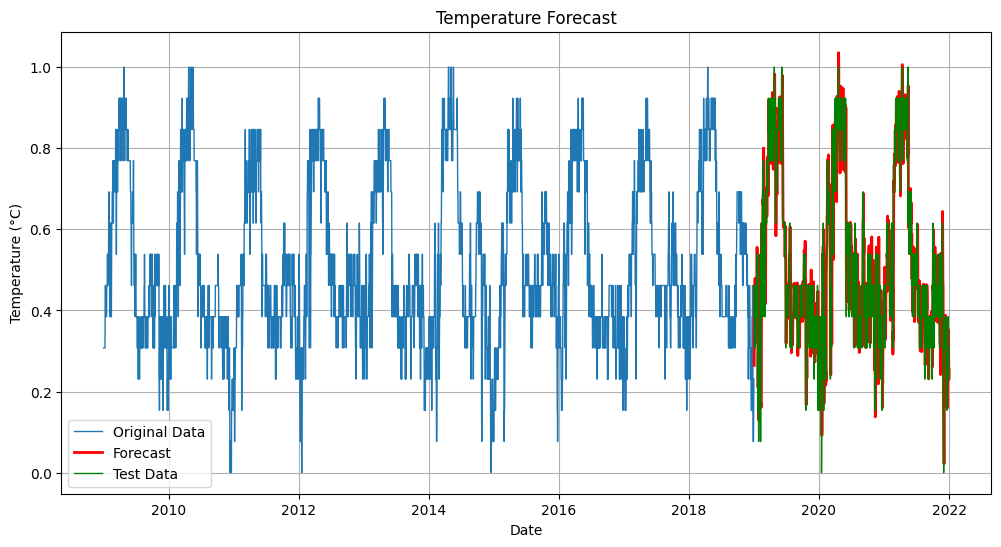

,predicted_mean
2019-01-02,0.264702
2019-01-03,0.383937
2019-01-04,0.458625
2019-01-05,0.441945
2019-01-06,0.460163
...,...
2021-12-27,0.300252
2021-12-28,0.352943
2021-12-29,0.309205
2021-12-30,0.229187


In [37]:
#Plotting the origonal training data, forecasted values, and actual test adata for comparsion
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['tempC'], label='Original Data', linewidth=1)
plt.plot(forecast_index, forecast, label='Forecast', color='red', linewidth=2)
plt.plot(test.index, test['tempC'], label='Test Data', color='green', linewidth=1)
plt.title('Temperature Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()

#Displaying the forecasted values
forecast


In [38]:
#Calculating and printing thr evalution metrics for the forecast: MAE, RMSE, R^2
mae = mean_absolute_error(test['tempC'], forecast)
print("MAE:", mae)# Mean Absolute Error

rmse = np.sqrt(mean_squared_error(test['tempC'], forecast))
print("RMSE:", rmse)# Root Mean Squared Error

r2 = r2_score(test['tempC'], forecast)
print("R²:", r2)# Coefficient of Determination


MAE: 0.046748429841852
RMSE: 0.06321175440368819
R²: 0.9059778209296673


FACEBOOK PROPHET MODEL

In [39]:
# Creating a new DataFrame from thr training data and removing the lag columns
wf_pro = pd.DataFrame(train)
wf_pro.drop(columns=['temp_lag_1', 'humidity_lag_1'],inplace = True)
# Adding a 'ds' column with datetime from the ndex and a 'y' column with the target variable('tempC')
wf_pro['ds'] = pd.to_datetime(train.index)
wf_pro['y'] = train['tempC']

# Displaying the first few steps of the processed DataFrame
wf_pro.head()

,tempC,humidity,pressure,ds,y
date_time,,,,,
2009-01-01,0.307692,0.306818,0.70,2009-01-01,0.307692
2009-01-02,0.307692,0.386364,0.75,2009-01-02,0.307692
2009-01-03,0.307692,0.420455,0.80,2009-01-03,0.307692
2009-01-04,0.307692,0.477273,0.75,2009-01-04,0.307692
2009-01-05,0.307692,0.465909,0.65,2009-01-05,0.307692


In [40]:
def prepare_prophet_data(train, test):
    """
    Prepares the training and test datasets for Prophet by creating 'ds' and 'y' columns
    and removing unnecessary lag columns.

    Parameters:
    - train: DataFrame containing the training data.
    - test: DataFrame containing the test data.

    Returns:
    - wf_pro: Processed training DataFrame with 'ds' and 'y' columns.
    - wf_pro_test: Processed test DataFrame with 'ds' and 'y' columns.
    """
    # Processing the train data
    wf_pro = pd.DataFrame(train)
    wf_pro.drop(columns=['temp_lag_1', 'humidity_lag_1'], inplace=True)  # Removing lag columns
    wf_pro['ds'] = pd.to_datetime(train.index)  # Adding 'ds' column with datetime
    wf_pro['y'] = train['tempC']  # Adding 'y' column with the target variable

    # Processing the test data
    wf_pro_test = pd.DataFrame(test)
    wf_pro_test.drop(columns=['temp_lag_1', 'humidity_lag_1'], inplace=True)  # Removing lag columns
    wf_pro_test['ds'] = pd.to_datetime(test.index)  # Adding 'ds' column with datetime
    wf_pro_test['y'] = test['tempC']  # Adding 'y' column with the target variable

    # Returning the processed DataFrames
    return wf_pro, wf_pro_test


In [42]:
wf_pro, wf_pro_test = prepare_prophet_data(train, test)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq4uy3e3u/d1f90nmg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq4uy3e3u/90q5lf6m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79625', 'data', 'file=/tmp/tmpq4uy3e3u/d1f90nmg.json', 'init=/tmp/tmpq4uy3e3u/90q5lf6m.json', 'output', 'file=/tmp/tmpq4uy3e3u/prophet_modelvxzr97yt/prophet_model-20250105130144.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:01:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:01:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


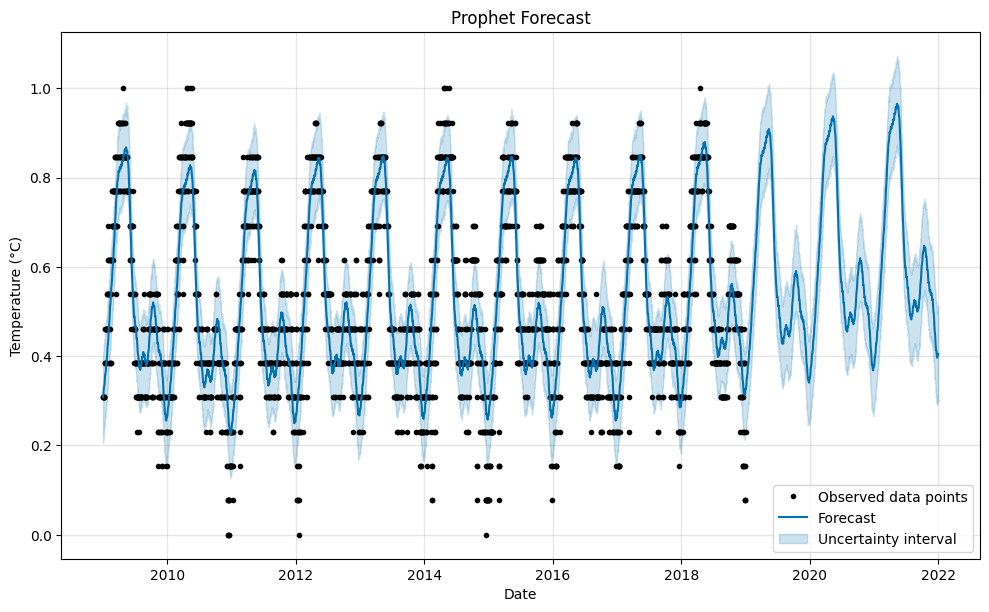

In [43]:
# Initializing and fitting the prophet model on the training data
model = Prophet(interval_width = 0.68)
model.fit(wf_pro)

# Creating a future DataFrame for predictions, with the same frequency as the test data
forecast_steps=len(wf_pro_test)
future = model.make_future_dataframe(periods=forecast_steps,freq='D')

# Generating the predictions for the future dates
forecast = model.predict(future)

# Displaying the key columns of the forecast, including predicted values('yhat') and confidence intervals
forecast[['ds', 'yhat', 'yhat_lower','yhat_upper', 'trend','trend_lower', 'trend_upper']].tail()

# Extracting true values and predictions for evaluation
y_true = wf_pro_test['y'].values  # Actual test values
y_pred = forecast['yhat'][-len(wf_pro_test):].values # Predicted values

#combining training and test data for visulization
wf_prophet = pd.concat([wf_pro,wf_pro_test])

#Plotting the Prophet forecast with observed data
prophet_plot_1 = model.plot(forecast, include_legend=True)
plt.title("Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.show()

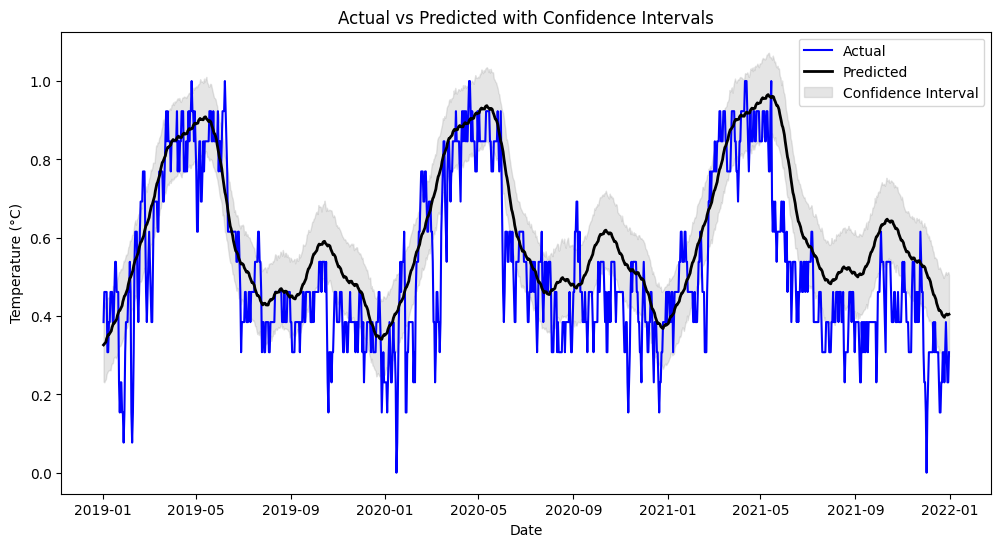

,yhat
0,0.308907
1,0.310593
2,0.312552
3,0.320928
4,0.326102
...,...
4743,0.403508
4744,0.405147
4745,0.402457
4746,0.403435


In [45]:
# Merge actual test data with the forecasted values, including the cinfindence intervals
forecast_actual = pd.merge(wf_pro_test, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

# Plot actual vs predicted values along with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(forecast_actual['ds'], forecast_actual['y'], label='Actual', color='blue')
plt.plot(forecast_actual['ds'], forecast_actual['yhat'], label='Predicted', color='black',linewidth=2)
plt.fill_between(forecast_actual['ds'],
                 forecast_actual['yhat_lower'],
                 forecast_actual['yhat_upper'],
                 color='gray', alpha=0.2, label='Confidence Interval')
plt.title("Actual vs Predicted with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

# Displaying the predicted values ('yhat') from the forecast
forecast['yhat']

In [46]:
# Calculating and printing the performance metrics to evaluate the model
print("Mean Squared Error (MSE):", mean_squared_error(y_true = wf_prophet["y"], y_pred = forecast['yhat']))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_true = wf_prophet["y"], y_pred = forecast['yhat']))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_true = wf_prophet["y"], y_pred = forecast['yhat'])))
print("R-squared (R²):", r2_score(y_true = wf_prophet["y"], y_pred = forecast['yhat']))

Mean Squared Error (MSE): 0.011477446767786083
Mean Absolute Error (MAE): 0.08179121184711043
Root Mean Squared Error (RMSE): 0.10713284635342274
R-squared (R²): 0.7181979238210471


cnn_lstm

(3563, 90, 4)
(3563,)
(1005, 90, 4)
(1005,)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 86, 128)             │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 43, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100)                 │          91,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,389 (368.71 KB)

 Trainable params: 94,389 (368.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - loss: 0.0459 - mae: 0.1473 - val_loss: 0.0130 - val_mae: 0.0868
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 0.0098 - mae: 0.0756 - val_loss: 0.0103 - val_mae: 0.0778
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0089 - mae: 0.0719 - val_loss: 0.0100 - val_mae: 0.0763
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 0.0084 - mae: 0.0690 - val_loss: 0.0098 - val_mae: 0.0750
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 0.0083 - mae: 0.0692 - val_loss: 0.0090 - val_mae: 0.0730
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.0083 - mae: 0.0698 - val_loss: 0.0084 - val_mae: 0.0698
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0080 - mae: 0.0675 - val_loss: 0.0081 - val_mae: 0.0691
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.0073 - mae: 0.0657 - val_loss: 0.0079 - val_mae: 0.0676
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 15s

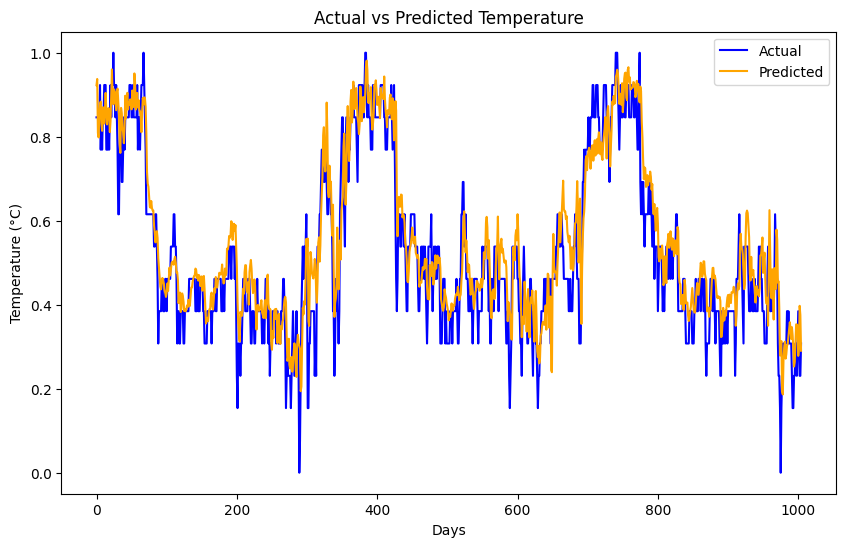

In [47]:
# Function to create sequences of input feature and target valuess for the time series data
def sequence_creating(data,seq_len,target_col = 'tempC'):
  X, y = [], []
  for i in range(len(data) - seq_len):
    X.append(data.iloc[i:i+seq_len, 1:].values)# Extracting feature sequences
    y.append(data.iloc[i+seq_len][target_col])# Extracting corresponding targets
  return np.array(X), np.array(y)

# Setting the sequence lenght for thr model and creatin train/test dataset
sequence_length = 90
X_train, y_train = sequence_creating(train,sequence_length)
X_test, y_test = sequence_creating(test,sequence_length)

# Printing the shapes of the input features and target arrays
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

#Building a CNN-LSTM model for time series prediction
model = Sequential()

# Convolution layer
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(sequence_length, X_train.shape[2])))

model.add(MaxPooling1D(pool_size=2)) # Max pooling layer

model.add(LSTM(100, activation='relu', return_sequences=False)) # LSTM layer

model.add(Flatten()) # Flattering the output

model.add(Dense(1)) # Dense layer for final output

# Compiling the modle with Adam optimizer and MSE loss
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Displaying the model summary
model.summary()

# Training the model on training data and validating on test data
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Predicting temperature values using the test data
y_pred = model.predict(X_test)

# Plotting actual vs predicted temperature values for comparison
plt.figure(figsize=(10, 6))
plt.plot(y_test.flatten(), label='Actual', color='blue')
plt.plot(y_pred.flatten(), label='Predicted', color='orange')
plt.title('Actual vs Predicted Temperature')
plt.xlabel('Days')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()



In [48]:
# Calculating and printing evaluation metric for the modles performance on the test dat
rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Root Mean Squared Error
mae = mean_absolute_error(y_test, y_pred) # Mean Absolute Error
r2 = r2_score(y_test, y_pred) # Coefficient of Determination

print("Test RMSE: ", rmse)
print("Test MAE: ", mae)
print("R²:", r2)

Test RMSE:  0.08976033917982813
Test MAE:  0.0688332402199746
R²: 0.8097622954572501


TEMPORAL FUSION TRANSFORMER MODEL

ARIMA MODEL FOR MANSOON SEASON

In [49]:
#wf.set_index('date_time', inplace=True)
#wf_seasons = wf[['precipMM','humidity','pressure']].resample('M').mean()
#wf_seasons.head()

In [50]:
wf.set_index('date_time', inplace=True)
wf_season_month = wf[['year','month','precipMM','humidity','pressure']]
wf_season_month.head()

,year,month,precipMM,humidity,pressure
date_time,,,,,
2009-01-01 00:00:00,2009,1,0.0,50,1013
2009-01-01 01:00:00,2009,1,0.0,46,1013
2009-01-01 02:00:00,2009,1,0.0,43,1013
2009-01-01 03:00:00,2009,1,0.0,40,1013
2009-01-01 04:00:00,2009,1,0.0,38,1013


In [51]:
def get_season(month):
    if month in [3, 4, 5]:
        return "summer"
    elif month in [6,7,8]:
        return "rainy"
    elif month in [9,10,11,]:
        return "spring"
    elif month in [12, 1, 2]:
        return "winter"
    else:
        return "Unknown"
#ipython-input-366-2d1aba2fb642


In [52]:
wf_season_month['season'] = wf_season_month['month'].apply(get_season)
wf_season_month.tail()

<ipython-input-52-7c8d05128f06>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wf_season_month['season'] = wf_season_month['month'].apply(get_season)


,year,month,precipMM,humidity,pressure,season
date_time,,,,,,
2021-12-31 19:00:00,2021,12,0.0,42,1016,winter
2021-12-31 20:00:00,2021,12,0.0,43,1017,winter
2021-12-31 21:00:00,2021,12,0.0,44,1018,winter
2021-12-31 22:00:00,2021,12,0.0,46,1017,winter
2021-12-31 23:00:00,2021,12,0.0,47,1017,winter


In [53]:
mansoon_data = wf_season_month[wf_season_month['season'] == 'rainy']
mansoon_data.head()

,year,month,precipMM,humidity,pressure,season
date_time,,,,,,
2009-06-01 00:00:00,2009,6,0.0,90,1007,rainy
2009-06-01 01:00:00,2009,6,0.0,91,1007,rainy
2009-06-01 02:00:00,2009,6,0.0,92,1007,rainy
2009-06-01 03:00:00,2009,6,0.0,94,1007,rainy
2009-06-01 04:00:00,2009,6,0.0,84,1007,rainy


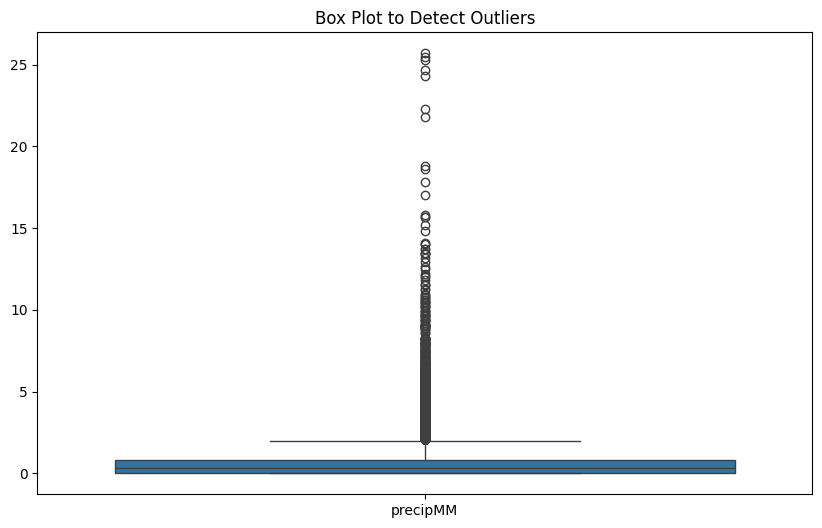

In [54]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=mansoon_data[['precipMM']])#, 'humidity']])
plt.title('Box Plot to Detect Outliers')
plt.show()

Q1 = mansoon_data['precipMM'].quantile(0.25)
Q3 = mansoon_data['precipMM'].quantile(0.75)
IQR = Q3 - Q1

#Q5 = wf['humidity'].quantile(0.25)
#Q7 = wf['humidity'].quantile(0.75)
#IQR1 = Q7 - Q5

outliers_precipMM = mansoon_data[(mansoon_data['precipMM'] < (Q1 - 1.5 * IQR)) | (mansoon_data['precipMM'] > (Q3 + 1.5 * IQR))]

In [55]:
print("Number of outliers in Temperature:", len(outliers_precipMM))

Number of outliers in Temperature: 2142


In [56]:
print("Original DataFrame shape:", mansoon_data.shape)
print(outliers_precipMM[['year', 'precipMM']])

Original DataFrame shape: (28704, 6)
                     year  precipMM
date_time                          
2009-06-06 15:00:00  2009       5.5
2009-06-20 06:00:00  2009       2.1
2009-06-20 08:00:00  2009       3.1
2009-06-20 09:00:00  2009       4.2
2009-06-20 10:00:00  2009       2.1
...                   ...       ...
2021-08-31 07:00:00  2021       3.8
2021-08-31 08:00:00  2021       3.4
2021-08-31 09:00:00  2021       3.3
2021-08-31 10:00:00  2021       3.2
2021-08-31 11:00:00  2021       2.8

[2142 rows x 2 columns]


In [57]:
wf_M= mansoon_data[(mansoon_data['precipMM'] >= (Q1 - 1.5 * IQR)) & (mansoon_data['precipMM'] <= (Q3 + 1.5 * IQR))]
wf_M.tail()

,year,month,precipMM,humidity,pressure,season
date_time,,,,,,
2021-08-31 19:00:00,2021,8,0.7,83,1007,rainy
2021-08-31 20:00:00,2021,8,0.5,85,1008,rainy
2021-08-31 21:00:00,2021,8,0.5,86,1008,rainy
2021-08-31 22:00:00,2021,8,0.4,87,1008,rainy
2021-08-31 23:00:00,2021,8,0.5,87,1008,rainy


Number of outliers in Temperature: 26562


,year,month,precipMM,humidity,pressure,season
date_time,,,,,,
2009-06-01 00:00:00,2009,6,0.0,90,1007,rainy
2009-06-01 01:00:00,2009,6,0.0,91,1007,rainy
2009-06-01 02:00:00,2009,6,0.0,92,1007,rainy
2009-06-01 03:00:00,2009,6,0.0,94,1007,rainy
2009-06-01 04:00:00,2009,6,0.0,84,1007,rainy


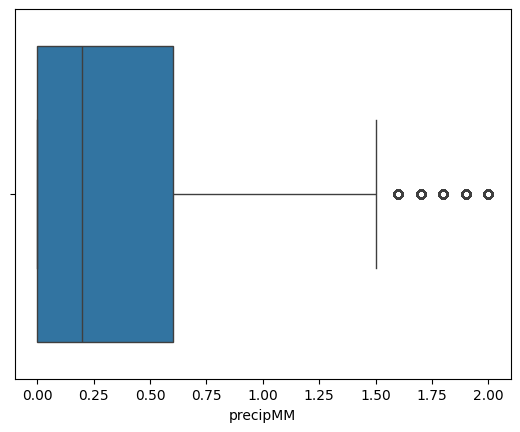

In [58]:
sns.boxplot(x=wf_M['precipMM'])
print("Number of outliers in Temperature:", len(wf_M))
wf_M.head()


In [59]:
wf_M.head()

,year,month,precipMM,humidity,pressure,season
date_time,,,,,,
2009-06-01 00:00:00,2009,6,0.0,90,1007,rainy
2009-06-01 01:00:00,2009,6,0.0,91,1007,rainy
2009-06-01 02:00:00,2009,6,0.0,92,1007,rainy
2009-06-01 03:00:00,2009,6,0.0,94,1007,rainy
2009-06-01 04:00:00,2009,6,0.0,84,1007,rainy


In [60]:
wf_mansoon = wf_M[['precipMM','humidity','pressure']].resample('D').mean()
wf_mansoon.head()

,precipMM,humidity,pressure
date_time,,,
2009-06-01,0.087500,67.375000,1007.083333
2009-06-02,0.150000,67.958333,1008.000000
2009-06-03,0.066667,68.375000,1008.958333
2009-06-04,0.133333,72.625000,1007.333333
2009-06-05,0.170833,76.041667,1005.000000


In [61]:
# Scale the selected columns and store the result in a temporary variable
scaled_data = scaler.fit_transform(wf_mansoon[['precipMM','humidity','pressure']])

# Assign the scaled values back to the original columns
wf_mansoon[['precipMM','humidity','pressure']] = scaled_data

In [62]:
wf_mansoon['precipMM_lag_1'] = wf_mansoon['precipMM'].shift(1)
wf_mansoon['humidity_lag_1'] = wf_mansoon['humidity'].shift(1)

In [63]:
missing_values = wf_mansoon.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 precipMM          3281
humidity          3281
pressure          3281
precipMM_lag_1    3282
humidity_lag_1    3282
dtype: int64


In [64]:
wf_mansoon.fillna(method = 'bfill',inplace=True)
wf_mansoon.head()

<ipython-input-64-38110a24eef2>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  wf_mansoon.fillna(method = 'bfill',inplace=True)


,precipMM,humidity,pressure,precipMM_lag_1,humidity_lag_1
date_time,,,,,
2009-06-01,0.046543,0.324733,0.691039,0.046543,0.324733
2009-06-02,0.079787,0.337189,0.759697,0.046543,0.324733
2009-06-03,0.035461,0.346085,0.831476,0.079787,0.337189
2009-06-04,0.070922,0.436833,0.709764,0.035461,0.346085
2009-06-05,0.090869,0.509786,0.534998,0.070922,0.436833


In [65]:
missing_values = wf_mansoon.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 precipMM          0
humidity          0
pressure          0
precipMM_lag_1    0
humidity_lag_1    0
dtype: int64


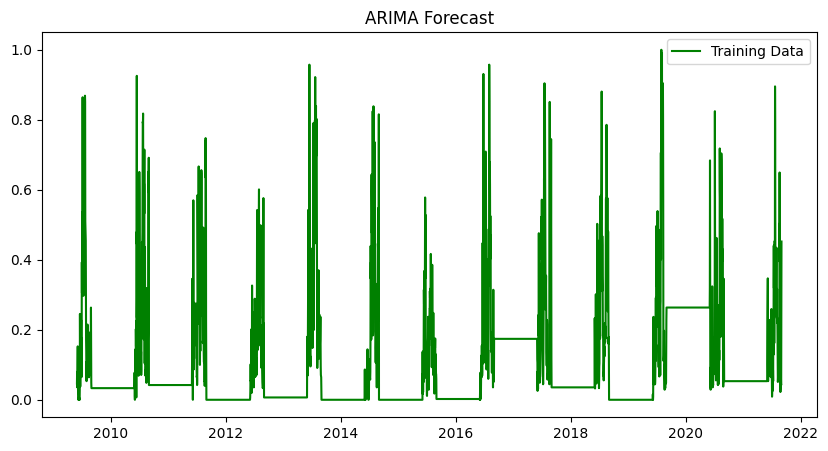

In [67]:
# Split into training and testing setstrain_size = int(len(wf_mansoon) * 0.8)  # 80% for training

#train_m = wf_mansoon.iloc[:train_size]
#test_m = wf_mansoon.iloc[train_size:]
train_m = wf_mansoon[wf_mansoon.index <= pd.to_datetime('2019-06-01')]  # Convert 2019 to a datetime object
test_m = wf_mansoon[wf_mansoon.index > pd.to_datetime('2019-06-01')]  # Convert 2019 to a datetime object
plt.figure(figsize=(10, 5))
plt.plot(wf_mansoon['precipMM'], label="Training Data", color="green")
#plt.plot(test_m['precipMM'], label="Validation Data", color="green")
#plt.plot(forecast_index, forecast, label="Forecast", color="red")
plt.legend()
plt.title("ARIMA Forecast")
plt.show()

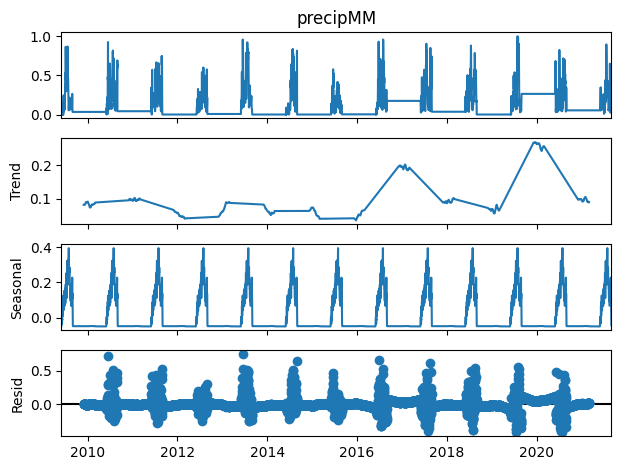

ADF Statistic: -5.667844086985084
p-value: 9.064904339519046e-07
The series is stationary.


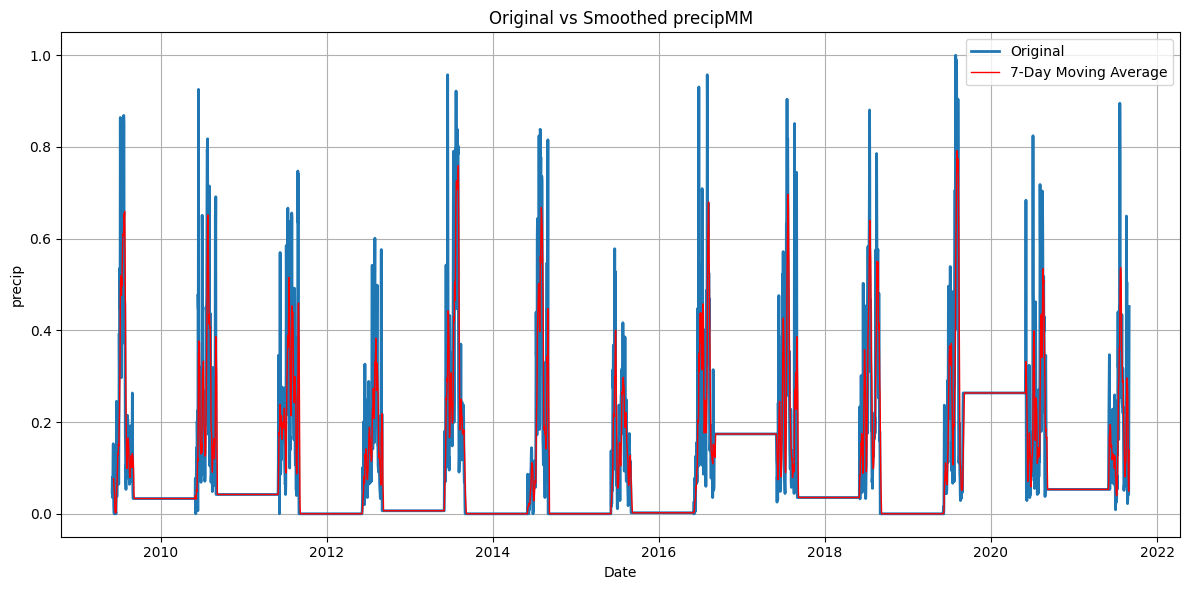

<Figure size 1200x600 with 0 Axes>

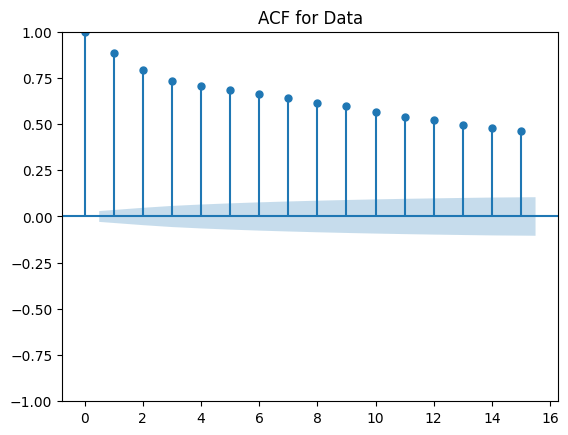

<Figure size 1200x600 with 0 Axes>

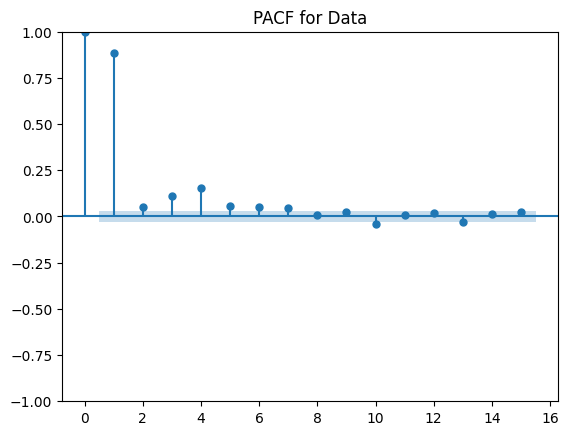

In [68]:

precipMM_result = seasonal_decompose(wf_mansoon['precipMM'], model='additive', period=365)
precipMM_result.plot()
plt.show()
check_stationarity(wf_mansoon['precipMM'])
precipMM_rolling = wf_mansoon['precipMM'].rolling(window=7).mean()
plt.figure(figsize=(12, 6))
plt.plot(wf_mansoon.index, wf_mansoon['precipMM'], label='Original', linewidth=2)
plt.plot(wf_mansoon.index, precipMM_rolling, label='7-Day Moving Average', color='red', linewidth=1)
plt.title('Original vs Smoothed precipMM')
plt.xlabel('Date')
plt.ylabel('precip')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plot_acf(wf_mansoon['precipMM'], lags=15)
plt.title('ACF for Data')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(wf_mansoon['precipMM'], lags=15)
plt.title('PACF for Data')
plt.show()

In [69]:

from pmdarima import auto_arima

auto_model = auto_arima(train_m['precipMM'],
                        start_p=0, start_q=0,
                        max_p=5, max_q=5,
                        d=None,
                        seasonal=False,
                        stepwise=True,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        max_order=None,
                        information_criterion='aic'
                        )


print(auto_model.summary())

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2573.387, Time=0.28 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-8920.426, Time=0.37 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-5566.034, Time=0.93 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-8931.232, Time=0.67 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-8981.801, Time=0.61 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-9100.963, Time=0.92 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-9112.426, Time=1.28 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-9127.003, Time=7.57 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-9125.119, Time=3.29 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(0,0,0)[0]             : AIC=-9121.156, Time=4.64 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-9126.888, Time=1.54 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=-9130.885, Time=12.32 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-9144.364, Time=10.59 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=-9125.287, Time=11.43 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-9127.950, Time=0.99 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-9144.074, Time=8.38 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-9021.099, Time=1.47 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-9130.845, Time=10.51 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-9136.310, Time=1.04 sec


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=-9140.464, Time=12.55 sec

Best model:  ARIMA(4,0,1)(0,0,0)[0] intercept
Total fit time: 91.427 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3653
Model:               SARIMAX(4, 0, 1)   Log Likelihood                4579.182
Date:                Sun, 05 Jan 2025   AIC                          -9144.364
Time:                        13:27:38   BIC                          -9100.941
Sample:                    06-01-2009   HQIC                         -9128.901
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0033      0.002      1.929      0.054    -5.2e-

In [70]:
m_model = ARIMA(train_m['precipMM'], order=(4, 0, 1),exog=train_m[['humidity', 'pressure','precipMM_lag_1','humidity_lag_1']])
m_model_fit = m_model.fit()
print(m_model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:               precipMM   No. Observations:                 3653
Model:                 ARIMA(4, 0, 1)   Log Likelihood                5103.990
Date:                Sun, 05 Jan 2025   AIC                         -10185.980
Time:                        13:28:06   BIC                         -10117.744
Sample:                    06-01-2009   HQIC                        -10161.680
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0197      0.004      4.794      0.000       0.012       0.028
humidity           0.6965      0.008     90.522      0.000       0.681       0.712
pressure          -0.0424      0.006

In [71]:
m_forecast_steps = len(test_m)
m_forecast = m_model_fit.forecast(steps=m_forecast_steps,exog=test_m[['humidity', 'pressure','precipMM_lag_1','humidity_lag_1']])
m_forecast_index = pd.date_range(start=test_m.index[0] + pd.Timedelta(days=1), periods=m_forecast_steps, freq='D')


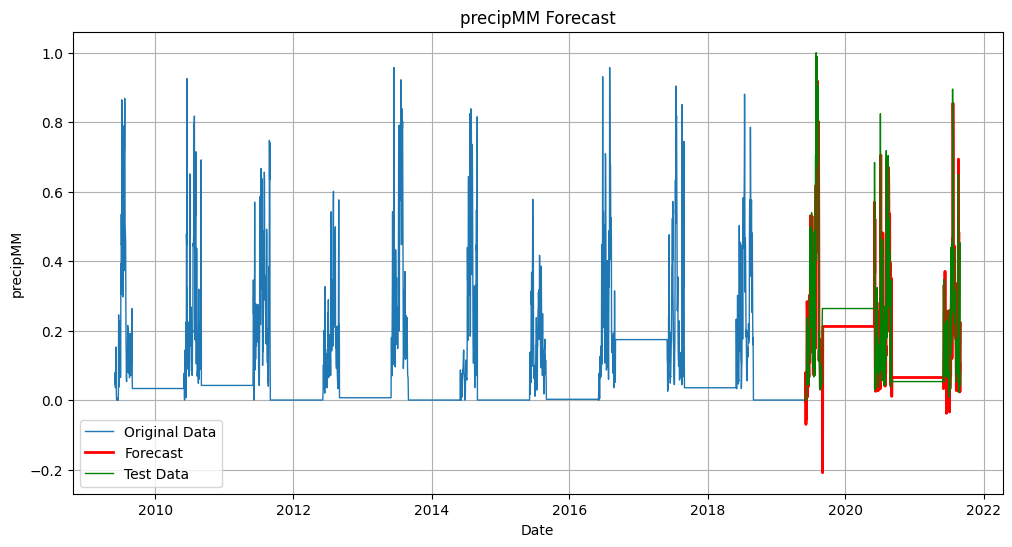

In [72]:


#outliers_humidity = wf[(wf['humidity'] < (Q5 - 1.5 * IQR)) | (wf['humidity'] > (Q7 + 1.5 * IQR))]

#print("Number of outliers in Humidity:", len(outliers_humidity))

#print(outliers_humidity[['year', 'humidity']])

plt.figure(figsize=(12, 6))
plt.plot(train_m.index, train_m['precipMM'], label='Original Data', linewidth=1)
plt.plot(m_forecast_index, m_forecast, label='Forecast', color='red', linewidth=2)
plt.plot(test_m.index, test_m['precipMM'], label='Test Data', color='green', linewidth=1)
plt.title('precipMM Forecast')
plt.xlabel('Date')
plt.ylabel('precipMM')
plt.legend()
plt.grid()
plt.show()


In [73]:
test_m.shape

(822, 5)

In [74]:
m_forecast.shape

(822,)

In [75]:

mae = mean_absolute_error(test_m['precipMM'], m_forecast)
print("MAE:", mae)
rmse = np.sqrt(mean_squared_error(test_m['precipMM'], m_forecast))
print("RMSE:", rmse)
r2 = r2_score(test_m['precipMM'], m_forecast)
print("R²:", r2)

MAE: 0.05201742303303912
RMSE: 0.0818816014136983
R²: 0.7121941630809965


prophet

In [76]:
wf_mansoon_m = pd.DataFrame(wf_mansoon)
wf_mansoon_m.drop(columns=['precipMM_lag_1', 'humidity_lag_1'],inplace = True)
wf_mansoon_m.head()


,precipMM,humidity,pressure
date_time,,,
2009-06-01,0.046543,0.324733,0.691039
2009-06-02,0.079787,0.337189,0.759697
2009-06-03,0.035461,0.346085,0.831476
2009-06-04,0.070922,0.436833,0.709764
2009-06-05,0.090869,0.509786,0.534998


In [77]:
wf_mansoon_m['ds'] = pd.to_datetime(wf_mansoon_m.index)
wf_mansoon_m['y'] = wf_mansoon_m['precipMM']
wf_mansoon_m.head()

#train_size = int(len(wf_mansoon_m) * 0.8)  # 80% for training
#train_m = wf_mansoon_m.iloc[:train_size]
#test_m = wf_mansoon_m.iloc[train_size:]

train_m_p = wf_mansoon_m[wf_mansoon_m.index <= pd.to_datetime('2019-06-01')]  # Convert 2019 to a datetime object
test_m_p = wf_mansoon_m[wf_mansoon_m.index > pd.to_datetime('2019-06-01')]  # Convert 2019 to a datetime object

In [78]:
m_p_model = Prophet(interval_width = 0.68)
m_p_model.fit(train_m_p)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq4uy3e3u/b1s06p9f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq4uy3e3u/8a4kvk1m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66754', 'data', 'file=/tmp/tmpq4uy3e3u/b1s06p9f.json', 'init=/tmp/tmpq4uy3e3u/8a4kvk1m.json', 'output', 'file=/tmp/tmpq4uy3e3u/prophet_modelsceym6ic/prophet_model-20250105132807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:28:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:28:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [79]:
m_p_forecast_steps=len(test_m_p)
m_p_future = m_p_model.make_future_dataframe(periods=forecast_steps,freq='D')

In [80]:
m_p_forecast = m_p_model.predict(m_p_future)
m_p_forecast[['ds', 'yhat', 'yhat_lower','yhat_upper', 'trend','trend_lower', 'trend_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper,trend,trend_lower,trend_upper
4743,2022-05-27,-0.191134,-0.325410,-0.065714,-0.133572,-0.212070,-0.055082
4744,2022-05-28,-0.182178,-0.318009,-0.056476,-0.133728,-0.212376,-0.055216
4745,2022-05-29,-0.173978,-0.301736,-0.045694,-0.133885,-0.212640,-0.055350
4746,2022-05-30,-0.167439,-0.297292,-0.029895,-0.134041,-0.212899,-0.055484
4747,2022-05-31,-0.159028,-0.291382,-0.033956,-0.134197,-0.213158,-0.055618


In [81]:
y_true = wf_mansoon_m['y'].values  # Replace 'y' with your target column name
y_pred = m_p_forecast['yhat'][:len(y_true)].values

In [82]:
wf_prophet_m = pd.concat([train_m_p,test_m_p])

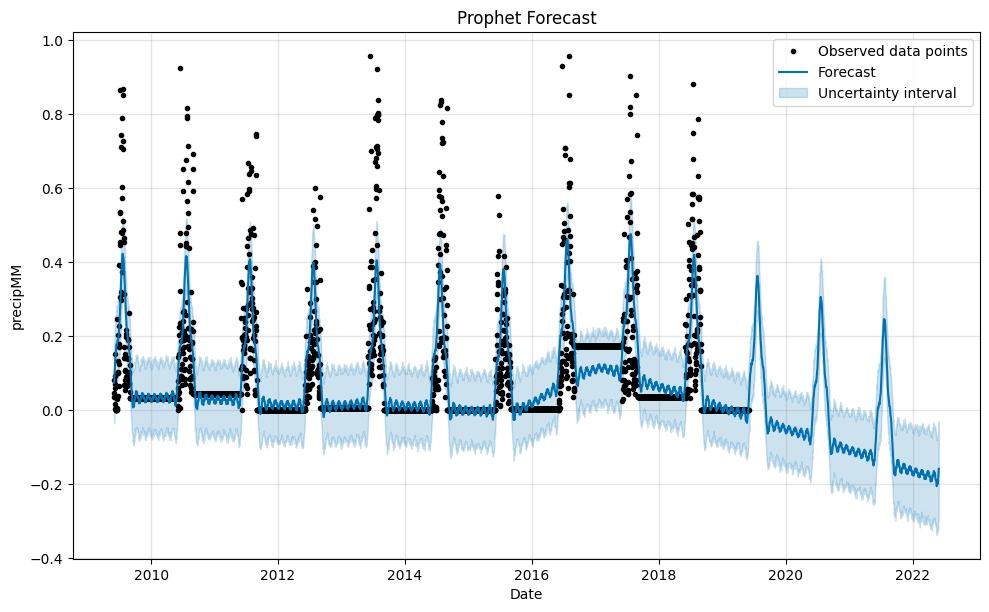

In [83]:
prophet_plot_2 = m_p_model.plot(m_p_forecast, include_legend=True)
plt.title("Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("precipMM")
plt.show()

In [84]:

# Merge actual and forecasted data
m_p_forecast_actual = pd.merge(test_m_p, m_p_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds', how='left')

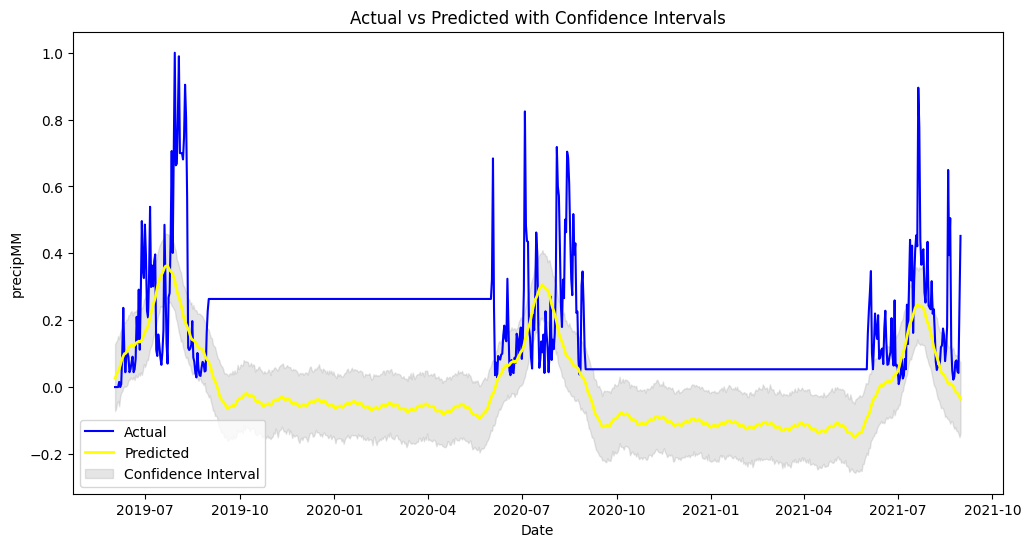

,yhat
0,0.073928
1,0.083423
2,0.087278
3,0.094186
4,0.104407
...,...
4743,-0.191134
4744,-0.182178
4745,-0.173978
4746,-0.167439


In [85]:


# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(m_p_forecast_actual['ds'], m_p_forecast_actual['y'], label='Actual', color='blue')
plt.plot(m_p_forecast_actual['ds'], m_p_forecast_actual['yhat'], label='Predicted', color='yellow',linewidth=2)
plt.fill_between(m_p_forecast_actual['ds'],
                 m_p_forecast_actual['yhat_lower'],
                 m_p_forecast_actual['yhat_upper'],
                 color='gray', alpha=0.2, label='Confidence Interval')
plt.title("Actual vs Predicted with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("precipMM")
plt.legend()
plt.show()

m_p_forecast['yhat']

In [86]:
# code
# Ensure y_pred has the same length as wf_prophet_m["y"]
y_pred_subset = m_p_forecast['yhat'][:len(wf_prophet_m["y"])]

In [87]:
# code
print("Mean Squared Error (MSE):", mean_squared_error(y_true = y_true, y_pred = y_pred))
print("Mean Absolute Error (MAE):", mean_absolute_error(y_true = y_true, y_pred = y_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(y_true = y_true, y_pred = y_pred)))
print("R-squared (R²):", r2_score(y_true = y_true, y_pred = y_pred))

Mean Squared Error (MSE): 0.018653041764115353
Mean Absolute Error (MAE): 0.08164523749839185
Root Mean Squared Error (RMSE): 0.1365761390731022
R-squared (R²): 0.21037114814624358


tunning

In [88]:
# Import the necessary module
import itertools

In [89]:
# Simplified hyperparameter grid
param_grid = {
    "changepoint_prior_scale": [0.01, 0.1, 0.5, 1.0],
    "seasonality_prior_scale": [0.1, 1.0, 10.0],
}

# Update the function and grid search accordingly
# Remove holidays_prior_scale from function arguments
def evaluate_prophet(data, changepoint_prior_scale, seasonality_prior_scale):
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale
    )
    model.fit(data)
    future = model.make_future_dataframe(periods=30)
    forecast = model.predict(future)
    forecast_trimmed = forecast[:len(data)]
    error = mean_absolute_error(data['y'], forecast_trimmed['yhat'])
    return error

# Update all_params and perform grid search
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

results = []
for params in all_params:
    error = evaluate_prophet(
        train_m_p,
        changepoint_prior_scale=params["changepoint_prior_scale"],
        seasonality_prior_scale=params["seasonality_prior_scale"]
    )
    results.append((params, error))

best_params, best_error = min(results, key=lambda x: x[1])

print("Best Parameters:", best_params)
print("Best Error (MAE):", best_error)


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq4uy3e3u/aa9eh723.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq4uy3e3u/9rbrg9ah.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72666', 'data', 'file=/tmp/tmpq4uy3e3u/aa9eh723.json', 'init=/tmp/tmpq4uy3e3u/9rbrg9ah.json', 'output', 'file=/tmp/tmpq4uy3e3u/prophet_model5mso95qb/prophet_model-20250105132810.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:28:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:28:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq4

Best Parameters: {'changepoint_prior_scale': 1.0, 'seasonality_prior_scale': 0.1}
Best Error (MAE): 0.046519060443078956


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq4uy3e3u/jthsq749.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq4uy3e3u/bm3vmn7i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71076', 'data', 'file=/tmp/tmpq4uy3e3u/jthsq749.json', 'init=/tmp/tmpq4uy3e3u/bm3vmn7i.json', 'output', 'file=/tmp/tmpq4uy3e3u/prophet_modelexw9mar1/prophet_model-20250105132837.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:28:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:28:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


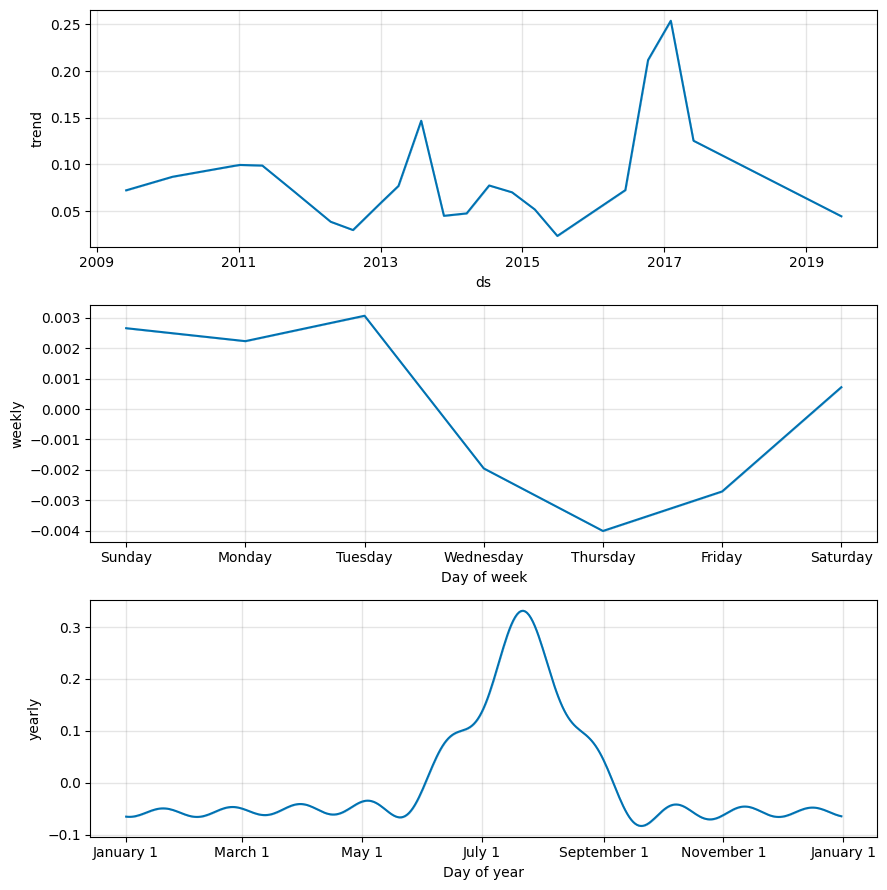

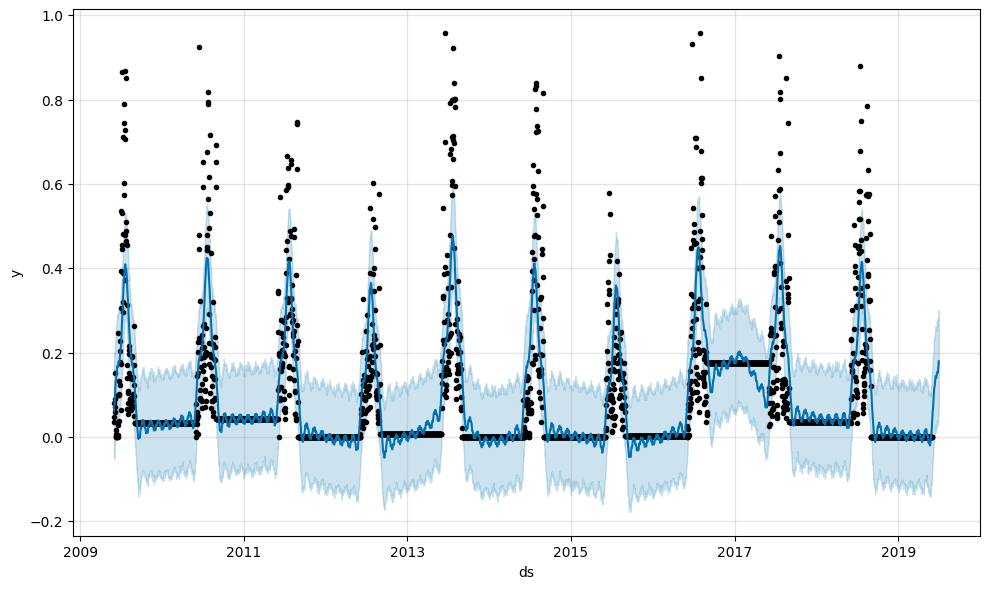

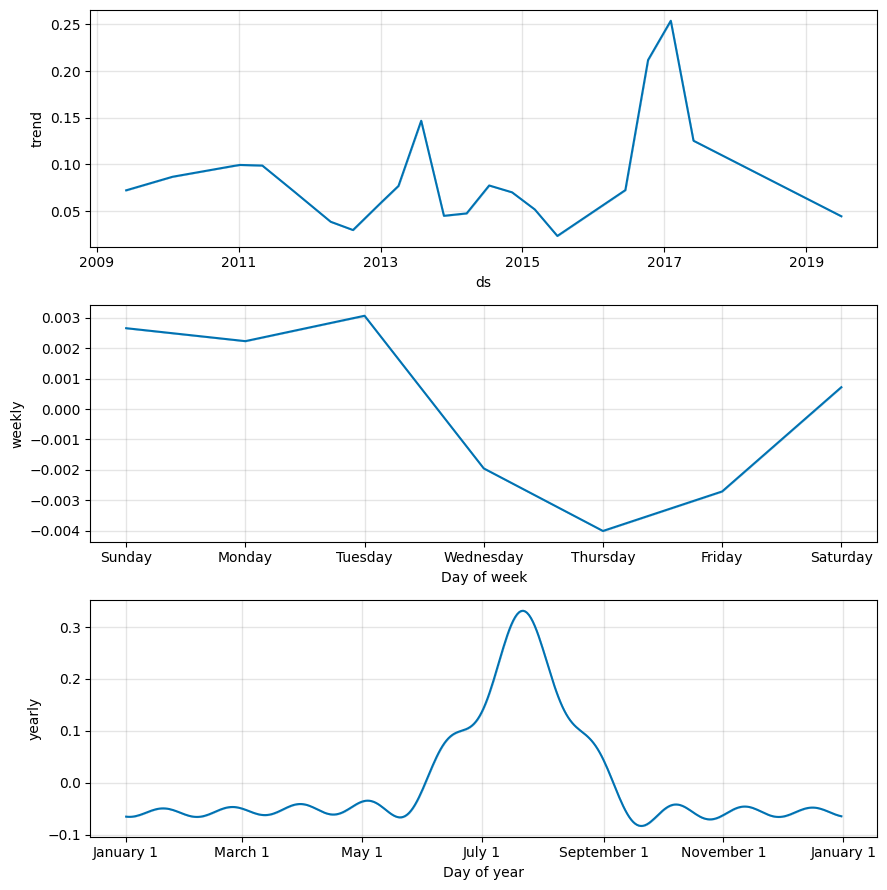

In [90]:
# Train the model with the best parameters
best_model = Prophet(
    changepoint_prior_scale=best_params["changepoint_prior_scale"],
    seasonality_prior_scale=best_params["seasonality_prior_scale"],
)
best_model.fit(train_m_p)

# Forecast future values
future = best_model.make_future_dataframe(periods=30)
forecast = best_model.predict(future)

# Plot the forecast
best_model.plot(forecast)
best_model.plot_components(forecast)


In [91]:
train_m_p.head()

,precipMM,humidity,pressure,ds,y
date_time,,,,,
2009-06-01,0.046543,0.324733,0.691039,2009-06-01,0.046543
2009-06-02,0.079787,0.337189,0.759697,2009-06-02,0.079787
2009-06-03,0.035461,0.346085,0.831476,2009-06-03,0.035461
2009-06-04,0.070922,0.436833,0.709764,2009-06-04,0.070922
2009-06-05,0.090869,0.509786,0.534998,2009-06-05,0.090869


In [92]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Merge forecasted values with the original data for comparison
forecast_evaluation = forecast.merge(wf_mansoon_m, on="ds", how="left", suffixes=("_forecast", "_actual"))

# Calculate metrics
y_actual = forecast_evaluation["y"].dropna()  # Drop any NaN values
y_pred = forecast_evaluation["yhat"][:len(y_actual)]  # Match the length of actual values

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_actual, y_pred)
print(f"Mean Absolute Error (MAE): {mae}")

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_actual, y_pred)
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

print("R-squared (R²):", r2_score(y_actual, y_pred))


Mean Absolute Error (MAE): 0.04686612653299208
Root Mean Squared Error (RMSE): 0.008855070461524247
Mean Absolute Percentage Error (MAPE): inf%
R-squared (R²): 0.5951200058633275


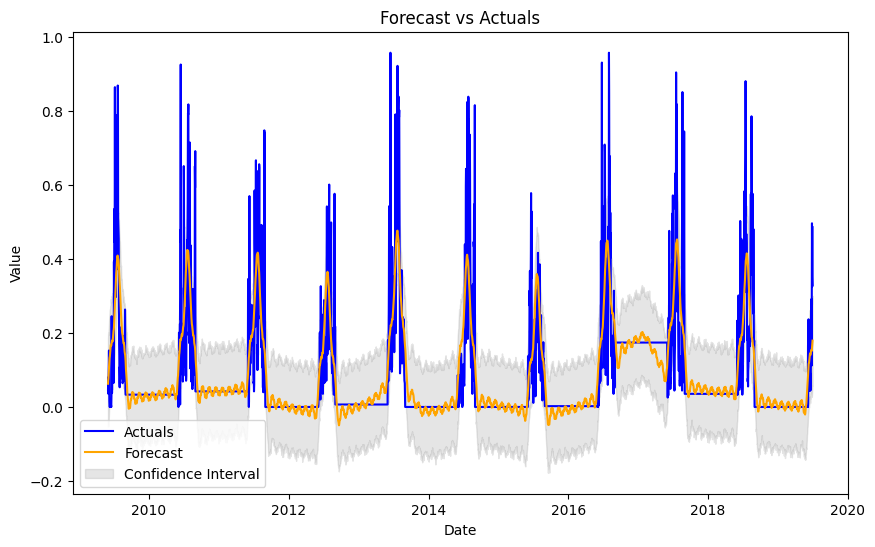

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(forecast_evaluation["ds"], forecast_evaluation["y"], label="Actuals", color="blue")
plt.plot(forecast_evaluation["ds"], forecast_evaluation["yhat"], label="Forecast", color="orange")
plt.fill_between(
    forecast_evaluation["ds"],
    forecast_evaluation["yhat_lower"],
    forecast_evaluation["yhat_upper"],
    color="gray",
    alpha=0.2,
    label="Confidence Interval"
)
plt.legend()
plt.title("Forecast vs Actuals")
plt.xlabel("Date")
plt.ylabel("Value")
plt.show()


Cnn-Lstm Model for Mansoon data

In [94]:
train_m.head()

,precipMM,humidity,pressure,precipMM_lag_1,humidity_lag_1
date_time,,,,,
2009-06-01,0.046543,0.324733,0.691039,0.046543,0.324733
2009-06-02,0.079787,0.337189,0.759697,0.046543,0.324733
2009-06-03,0.035461,0.346085,0.831476,0.079787,0.337189
2009-06-04,0.070922,0.436833,0.709764,0.035461,0.346085
2009-06-05,0.090869,0.509786,0.534998,0.070922,0.436833


In [100]:
def sequence_creating(data,seq_len,target_col):
  X, y = [], []
  for i in range(len(data) - seq_len):
    X.append(data.iloc[i:i+seq_len, 1:].values)
    y.append(data.iloc[i+seq_len][target_col])
  return np.array(X), np.array(y)


sequence_length = 90
target_column = 'precipMM'

X_train, y_train = sequence_creating(train_m,sequence_length,target_column)
X_test, y_test = sequence_creating(test_m,sequence_length,target_column)


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3563, 90, 4)
(3563,)
(732, 90, 4)
(732,)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 86, 128)             │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 43, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 100)                 │          91,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,389 (368.71 KB)

 Trainable params: 94,389 (368.71 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.0129 - mae: 0.0638 - val_loss: 0.0267 - val_mae: 0.1379
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 78ms/step - loss: 0.0080 - mae: 0.0450 - val_loss: 0.0251 - val_mae: 0.1436
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 0.0086 - mae: 0.0463 - val_loss: 0.0208 - val_mae: 0.1245
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0081 - mae: 0.0446 - val_loss: 0.0198 - val_mae: 0.1291
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 58ms/step - loss: 0.0080 - mae: 0.0434 - val_loss: 0.0186 - val_mae: 0.1217
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - loss: 0.0079 - mae: 0.0419 - val_loss: 0.0167 - val_mae: 0.1147
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step - loss: 0.0079 - mae: 0.0441 - val_loss: 0.0166 - val_mae: 0.1146
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 0.0067 - mae: 0.0376 - val_loss: 0.0166 - val_mae: 0.0973
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 

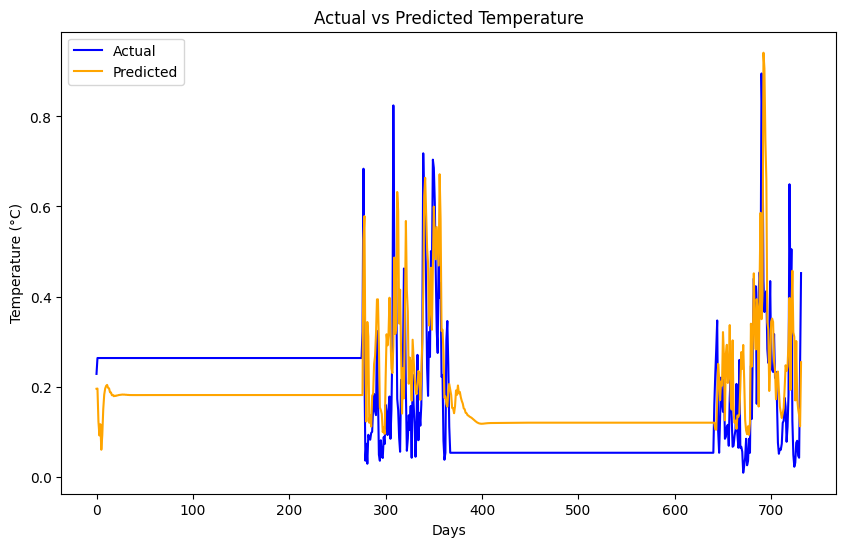

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [101]:


model_man = Sequential()

model_man.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(sequence_length, X_train.shape[2])))

model_man.add(MaxPooling1D(pool_size=2))

model_man.add(LSTM(100, activation='relu', return_sequences=False))

model.add(Flatten())

model_man.add(Dense(1))
model_man.compile(optimizer='adam', loss='mse', metrics=['mae'])


model_man.summary()


history = model_man.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

y_pred = model_man.predict(X_test)
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot(y_test.flatten(), label='Actual', color='blue')
plt.plot(y_pred.flatten(), label='Predicted', color='orange')
plt.title('Actual vs Predicted Temperature')
plt.xlabel('Days')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

test.shape


y_pred = model_man.predict(X_test)


In [102]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Test RMSE: ", rmse)
print("Test MAE: ", mae)
print("R²:", r2)

Test RMSE:  0.11187305594274095
Test MAE:  0.09246060047008696
R²: 0.2619375632702735
